In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
import os
from graspy.plot import heatmap
import matplotlib.pyplot as plt
%matplotlib inline 
from tqdm import tqdm

### Data Paths

In [21]:
data_dir = Path('/mnt/c/Users/Ronan Perry/Documents/JHU/jovo-lab/multiview/data')

fmri_dir = data_dir / 'raw' / 'fMRI' / 'REST_Data'
fmri_metadata_path = data_dir / 'raw' / 'fMRI' / 'SubjectsIDs_Schaefer_rest_Alone.csv'

sc_dir = data_dir / 'raw' / 'structural' / 'Deterministic_FA'
sc_metadata_path = data_dir / 'raw' / 'structural' / 'SubjectsIDs_Schaefer_Diffusion.csv'

demographics_path = data_dir / 'raw' / 'Demographics_MedicalFilter.csv'
clinical_path = data_dir / 'raw' / 'Cognitive_MedicalFilter.csv'
schaefer_coords_path = data_dir / 'supplementary' / 'Schaefer2018_400Parcels_17Networks_order.txt'

### Load Metadata

In [3]:
fmri_metadata = pd.read_csv(fmri_metadata_path)
sc_metadata = pd.read_csv(sc_metadata_path)
demographics = pd.read_csv(demographics_path)
clinical_scores = pd.read_csv(clinical_path)

### Load fMRI Scans

In [4]:
fmri_files = [f for f in os.listdir(fmri_dir)]
fmri_ids = [f.split('_')[0] for f in os.listdir(fmri_dir)]
fmri_bblids = [fmri_metadata.query(f'scanid == {idx}')['bblid'].iloc[0] for idx in fmri_ids]

In [6]:
names = None
sc_bblids = [int(f.split('_')[0]) for f in os.listdir(sc_dir)]
sc_files = [f for f in os.listdir(sc_dir)]

#for f in os.listdir(sc_dir):
#    # one-liner to read a single variable
#    names = loadmat(sc_dir / f)['name'][0]
#    sc_files.append(loadmat(sc_dir / f)['connectivity'])

## Get Matched Indices

In [7]:
def get_matched_indices(x,y):
    """
    Returns indices of all shared elements of two lists
    """
    matches = set(x).intersection(set(y))
    return(([x.index(i) for i in matches], [y.index(i) for i in matches]))

In [8]:
idx_fmri, idx_sc = get_matched_indices(fmri_bblids, sc_bblids)

In [9]:
fmri_mats_matched = [fmri_files[i] for i in idx_fmri]
fmri_bblids_matched = [fmri_bblids[i] for i in idx_fmri]

sc_mats_matched = [sc_files[i] for i in idx_sc]
sc_bblids_matched = [sc_bblids[i] for i in idx_sc]

print(f'There are {len(np.where(not sc_bblids_matched == fmri_bblids_matched)[0])} mismatches')

bblids = sc_bblids_matched

There are 0 mismatches


## Load Covariates

In [84]:
## Sex
sexes = [demographics.query(f'bblid == {bblid}')['sex'].iloc[0] for bblid in bblids]
## Age
ages = [demographics.query(f'bblid == {bblid}')['ageAtCnb1'].iloc[0] for bblid in bblids]

In [143]:
## RMS Motion for fmri scans of matched bblids
fmri_ids_matched = [fmri_ids[i] for i in idx_fmri]
fmri_rms_motion = list(fmri_metadata[fmri_metadata['bblid'].isin(bblids)]['restRelMeanRMSMotion'])

## RMS Motion for sc scans of matched bblids
sc_rms_motion = list(sc_metadata[sc_metadata['bblid'].isin(bblids)]['dti64MeanRelRMS'])

In [172]:
fmri_covariates = np.vstack([sexes, ages, fmri_rms_motion]).T
sc_covariates = np.vstack([sexes, ages, sc_rms_motion]).T

## Load SC Subject

In [28]:
idx = 10
subj = loadmat(sc_dir / sc_files[idx])['connectivity']

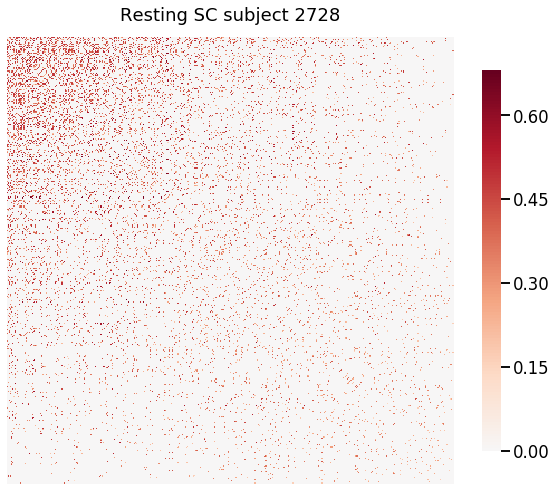

In [34]:
fig = heatmap(subj, title=f'Resting SC subject {fmri_ids[idx]}',transform=None)
plt.show()

## Load fMRI Subject

In [24]:
idx = 40
subj = np.genfromtxt(fmri_dir / fmri_files[idx], delimiter=' ')

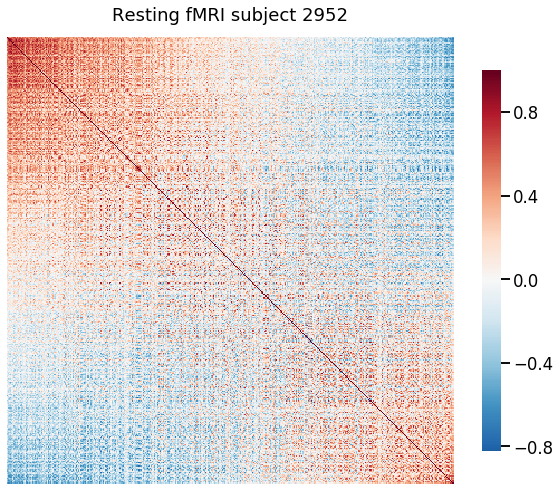

In [25]:
fig = heatmap(subj, title=f'Resting fMRI subject {fmri_ids[idx]}')
plt.show()

In [30]:
## RMS Motion
subj_rms_motion = fmri_metadata.query(f'scanid == {fmri_ids[idx]}')['restRelMeanRMSMotion'].iloc[0]
print(f'RMS Motion: {subj_rms_motion}')
subj_bblid = fmri_metadata.query(f'scanid == {fmri_ids[idx]}')['bblid'].iloc[0]
## Sex
subj_sex = demographics.query(f'bblid == {subj_bblid}')['sex'].iloc[0]
print(f'Sex: {subj_sex}')
## Age
subj_age = demographics.query(f'bblid == {subj_bblid}')['ageAtCnb1'].iloc[0]
print(f'Age: {subj_age}')

RMS Motion: 0.0225915
Sex: 1
Age: 244.0


## Regress out Covariates: voxel-wise

In [63]:
from sklearn.linear_model import LinearRegression
import pickle

In [185]:
def regress_from_voxel(X, y, return_coef=False):
    """
    y : List of voxels across subjects
    X : list of covariates
    
    returns : list of voxels w/ covariates regressed out
    """
    reg = LinearRegression().fit(X, y)
    
    if return_coef:
        return(reg.coef_)
    else:
        return(y - reg.predict(X))

## Load and Regress fMRI scans

In [183]:
fmri_mats = []
y = []
i = 0
j = 1
for fmri_file in tqdm([fmri_files[i] for i in idx_fmri]):
    subj = np.genfromtxt(fmri_dir / fmri_file, delimiter=' ')
    #y.append(subj[i,j])
    fmri_mats.append(subj)


100%|██████████| 926/926 [02:10<00:00,  6.74it/s]

In [181]:
yhat = regress_from_voxel(fmri_covariates[:len(y),:], np.array(y).reshape(-1,1))

In [190]:
## fmri coefficients

coefs = np.zeros((400,400,3))

for i in tqdm(range(400)):
    for j in range(400):
        coef = regress_from_voxel(fmri_covariates, [fmri_mat[i,j] for fmri_mat in fmri_mats], return_coef=True)
        
        coefs[i,j,:] = coef


100%|██████████| 400/400 [02:36<00:00,  2.90it/s]

In [193]:
#with open(data_dir / 'regressed_out' / 'fmri_linreg_coeffs.pkl', "wb") as output_file:
#    pickle.dump(coefs, output_file)

In [ ]:
with open(data_dir / 'regressed_out' / 'fmri_linreg_coeffs.pkl', "rb") as read_file:
    ceofs = pickle.load(read_file)

In [208]:
for bblid, fmri_mat, fmri_covariate in tqdm(zip(bblids, fmri_mats, fmri_covariates)):
    regressed_out = fmri_mat - coefs @ fmri_covariate
    np.savetxt(data_dir / 'regressed_out' / 'fMRI' / 'REST_Data' / f'bblid-{bblid}_Schaeffer400_network.csv', regressed_out, delimiter=',')


0it [00:00, ?it/s]
1it [00:00,  5.34it/s]
2it [00:00,  5.15it/s]
3it [00:00,  4.90it/s]
4it [00:00,  4.96it/s]
5it [00:00,  5.18it/s]
6it [00:01,  5.32it/s]
7it [00:01,  5.40it/s]
8it [00:01,  5.44it/s]
9it [00:01,  5.49it/s]
10it [00:01,  5.59it/s]
11it [00:02,  5.50it/s]
12it [00:02,  5.25it/s]
13it [00:02,  5.42it/s]
14it [00:02,  5.51it/s]
15it [00:02,  5.27it/s]
16it [00:03,  5.39it/s]
17it [00:03,  5.64it/s]
18it [00:03,  6.03it/s]
19it [00:03,  6.02it/s]
20it [00:03,  6.21it/s]
21it [00:03,  5.67it/s]
22it [00:04,  5.18it/s]
23it [00:04,  5.13it/s]
24it [00:04,  5.38it/s]
25it [00:04,  3.64it/s]
26it [00:05,  3.19it/s]
27it [00:05,  3.46it/s]
28it [00:05,  3.87it/s]
29it [00:05,  4.23it/s]
30it [00:06,  4.47it/s]
31it [00:06,  4.51it/s]
32it [00:06,  4.57it/s]
33it [00:06,  4.94it/s]
34it [00:06,  5.11it/s]
35it [00:07,  5.34it/s]
36it [00:07,  5.76it/s]
37it [00:07,  5.72it/s]
38it [00:07,  5.63it/s]
39it [00:07,  6.00it/s]
40it [00:07,  5.85it/s]
41it [00:08,  6.12it/s]
42it 